In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight

In [2]:
# load input data
!wget https://raw.githubusercontent.com/zuzanaSKB/machine-learning-project/refs/heads/main/hw_echo_pinatrace.txt

--2025-01-06 23:17:11--  https://raw.githubusercontent.com/zuzanaSKB/machine-learning-project/refs/heads/main/hw_echo_pinatrace.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4339498 (4.1M) [text/plain]
Saving to: ‘hw_echo_pinatrace.txt’

hw_echo_pinatrace.t 100%[===================>]   4.14M  11.2MB/s    in 0.4s    

2025-01-06 23:17:12 (11.2 MB/s) - ‘hw_echo_pinatrace.txt’ saved [4339498/4339498]



In [3]:
# preprocess input data

def parse_pintrace_file():
    entries = []
    with open('hw_echo_pinatrace.txt', 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) < 4:
                continue

            addr = parts[0].rstrip(':')
            addr = int(addr, 16)
            # operation write -> 1 and read -> 0
            operation = 1 if parts[1] == 'W' else 0
            instr_ptr = int(parts[2], 16)
            size = int(parts[3])      # Size in bytes
            next_addr = int(parts[4], 16) if len(parts) > 4 and parts[4] != '0' else 0
            next_addr = min(next_addr, np.finfo(np.float32).max)


            # append to list
            entries.append({
                "addr": addr,
                "operation": operation,
                "instr_ptr": instr_ptr,
                "size": size,
                "next_addr": next_addr
            })

    return pd.DataFrame(entries)


# address delta
def calculate_addr_delta(df):
    df['addr_delta'] = df['addr'].diff().fillna(0).astype('int64')

# access frequency
def calculate_access_frequency(df):
    address_freq = df['addr'].value_counts()
    df['freq'] = df['addr'].map(address_freq)

# instruction pointer reuse
def calculate_instr_reuse(df):
    instr_ptr_reuse = df['instr_ptr'].value_counts()
    df['instr_reuse'] = df['instr_ptr'].map(instr_ptr_reuse)

# temporal gap
def calculate_temporal_gap(df):
    df['temporal_gap'] = df.groupby('addr').cumcount()

# spatial locality - check if addresses are close (same page)
def calculate_spatial_locality(df, page_size=4096):
    df['spatial_locality'] = df['addr'].apply(lambda x: (x // page_size))

# next address presence
def calculate_next_addr_present(df):
    df['next_addr_present'] = df['next_addr'].apply(lambda x: 0 if x == 0 else 1)


def process_trace_data():
    # parse the file
    df = parse_pintrace_file()

    # add features
    calculate_addr_delta(df)
    calculate_access_frequency(df)
    calculate_instr_reuse(df)
    calculate_temporal_gap(df)
    calculate_spatial_locality(df)
    calculate_next_addr_present(df)

    # print(df.head())
    return df

# process data and save to df
df = process_trace_data()


In [5]:
# RandomForestClassifier
# predict operation (read (0) or write (1))

# divide data into training (80%) and testing (20%) set
X = np.array(df.drop(columns=['operation']))
y = np.array(df['operation'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfc = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=20)
rfc.fit(X_train, y_train)

y_result = rfc.predict(X_test)
score = accuracy_score(y_test, y_result)
classification = classification_report(y_test, y_result)

print("Accuracy:", score)
print("Classification :\n", classification)



Accuracy: 0.9540577716643741
Classification :
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     10524
           1       0.92      0.91      0.92      4016

    accuracy                           0.95     14540
   macro avg       0.94      0.94      0.94     14540
weighted avg       0.95      0.95      0.95     14540



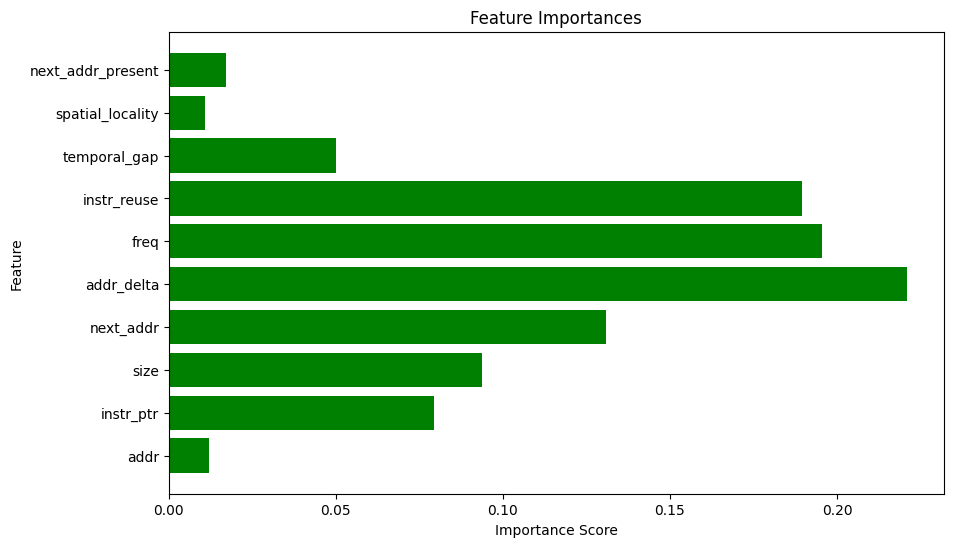

In [6]:
 Get feature importances
importances = rfc.feature_importances_
features = df.drop(columns=['operation']).columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='green')
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


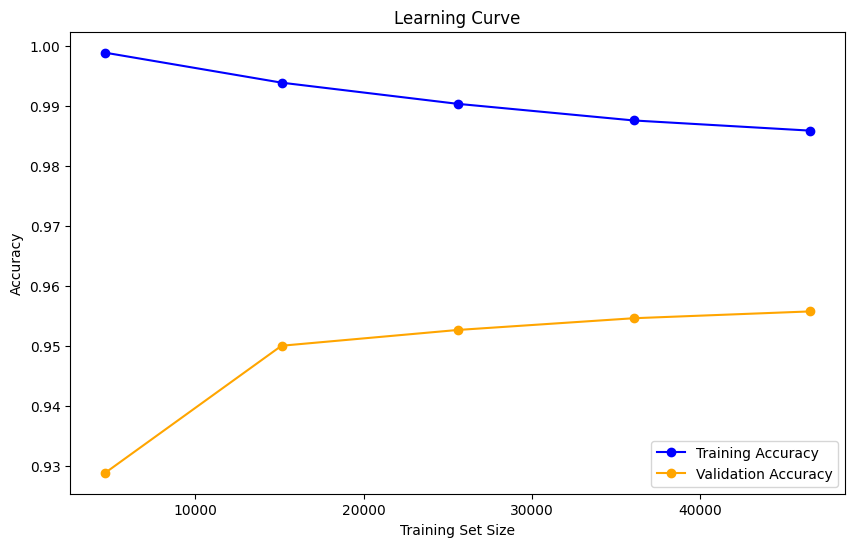

In [7]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rfc, X_train, y_train, cv=5, scoring='accuracy')
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy", color="blue", marker='o')
plt.plot(train_sizes, test_mean, label="Validation Accuracy", color="orange", marker='o')
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()


In [8]:
# Neural Network
# classify r / w operation

# divide data into training (80%) and testing (20%) set
X = np.array(df.drop(columns=['operation']))
y = np.array(df['operation'])
#scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

mlp = Sequential()
mlp.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
mlp.add(Dense(32, activation='relu'))
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))

mlp.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate=0.001),  metrics=['accuracy'])
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))
history = mlp.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights)

y_result = (mlp.predict(X_test) > 0.5).astype("int32")
score = accuracy_score(y_test, y_result)
classification = classification_report(y_test, y_result)

print("Neural Network Accuracy:", score)
print("Neural Network Classification:\n", classification)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6910 - loss: 0.5282 - val_accuracy: 0.7261 - val_loss: 0.5011
Epoch 2/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7280 - loss: 0.4595 - val_accuracy: 0.7388 - val_loss: 0.4576
Epoch 3/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7334 - loss: 0.4428 - val_accuracy: 0.7399 - val_loss: 0.4710
Epoch 4/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7340 - loss: 0.4347 - val_accuracy: 0.7404 - val_loss: 0.4437
Epoch 5/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7343 - loss: 0.4326 - val_accuracy: 0.7459 - val_loss: 0.4593
Epoch 6/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7398 - loss: 0.4265 - val_accuracy: 0.7581 - val_loss: 0.4389
Epoch 7/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7511 - loss: 0.4201 - val_accuracy: 0.7589 - val_loss: 0.4426
Epoch 8/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7552 - loss: 0.4139 - 

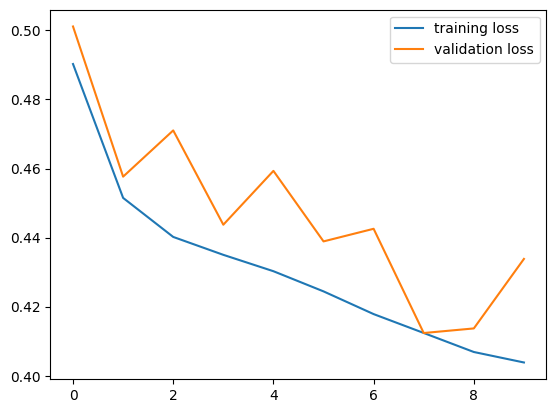

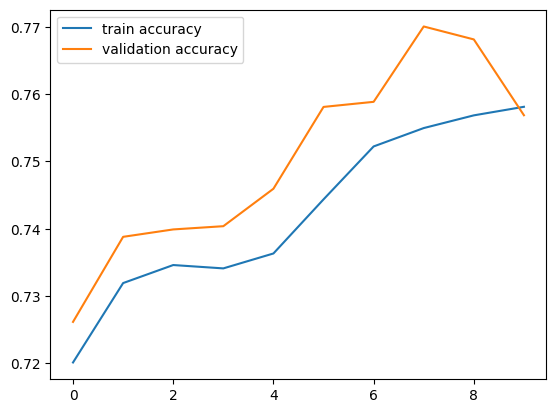

In [9]:
t.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')
plt.show()

In [10]:
# SVM
# classify r / w operation

# divide data into training (80%) and testing (20%) set
X = np.array(df.drop(columns=['operation']))
y = np.array(df['operation'])
# X = X.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train, y_train)
y_result = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_result)
classification = classification_report(y_test, y_result)

print("SVM Accuracy: ", accuracy)
print("SVM Classification Report:\n", classification)

SVM Accuracy:  0.7539202200825309
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.96      0.85     10524
           1       0.67      0.22      0.33      4016

    accuracy                           0.75     14540
   macro avg       0.71      0.59      0.59     14540
weighted avg       0.74      0.75      0.71     14540



In [13]:

# something i wanted to do also but didn't have enough time
# add another feature and classify the addressies based on memory access pattern (sequential/ random)
# memory access pattern classification
def classify_memory_access_patterns(df):
    # sequential vs random access
    # sequential = 1, random = 0
    df['sequential_access'] = np.where(df['addr_delta'].abs() <= df['addr_delta'].abs().median(), 1, 0)
    return df

df = classify_memory_access_patterns(df)
#print(df.head())

              addr  operation        instr_ptr  size        next_addr  \
0  123680716817731          1  140731905595736     8  123680716817736   
1  123680716820948          1  140731905595728     8                0   
2  123680716820980          1  140731905595720     8                0   
3  123680716820982          1  140731905595712     8                0   
4  123680716820984          1  140731905595704     8                0   

   addr_delta  freq  instr_reuse  temporal_gap  spatial_locality  \
0           0     1            7             0       30195487504   
1        3217     1            5             0       30195487505   
2          32     1            5             0       30195487505   
3           2     1            5             0       30195487505   
4           2     1            5             0       30195487505   

   next_addr_present  sequential_access  
0                  1                  1  
1                  0                  0  
2                  0      

In [ ]:
# Neural Network
# classify the memory access pattern (sequential/ random)

# divide data into training (80%) and testing (20%) set
X = np.array(df.drop(columns=['sequential_access']))
y = np.array(df['sequential_access'])
X = X.astype('float32')
# scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

mlp = Sequential()
mlp.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))

mlp.compile(loss='binary_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))

history = mlp.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights)

mlp_result = np.argmax(mlp.predict(X_test), axis=1)
score = accuracy_score(y_test, mlp_result)
classification = classification_report(y_test, mlp_result)

print("Neural Network Accuracy:", score)
print("Neural Network Classification:\n", classification)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1818/1818 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6297 - loss: 0.6504 - val_accuracy: 0.6750 - val_loss: 0.5942
Epoch 2/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6820 - loss: 0.5818 - val_accuracy: 0.7000 - val_loss: 0.5636
Epoch 3/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7104 - loss: 0.5532 - val_accuracy: 0.7176 - val_loss: 0.5473
Epoch 4/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7201 - loss: 0.5406 - val_accuracy: 0.7194 - val_loss: 0.5346
Epoch 5/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7227 - loss: 0.5301 - val_accuracy: 0.7195 - val_loss: 0.5261
Epoch 6/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7248 - loss: 0.5215 - val_accuracy: 0.7217 - val_loss: 0.5195
Epoch 7/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7224 - loss: 0.5194 - val_accuracy: 0.7236 - val_loss: 0.5148
Epoch 8/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7247 - loss: 0.5139 - val_accurac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


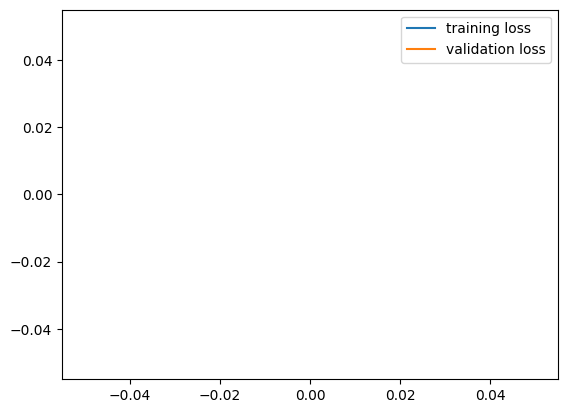

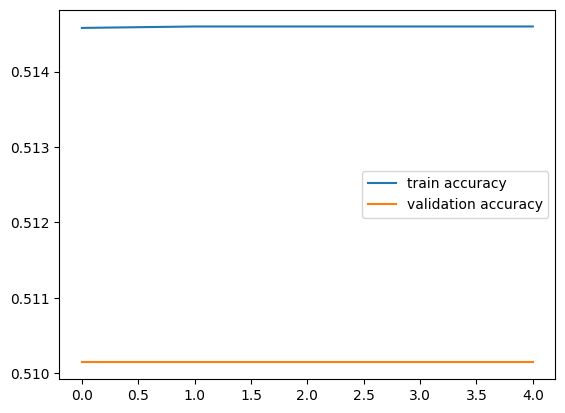

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
score = mlp.evaluate(X_test, y_test_encoded)
print("\n\nloss: {} | train acc: {}".format(score[0], score[1]))

455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5124 - loss: nan


loss: nan | train acc: 0.5123796463012695


In [ ]:
# SVM

# divide data into training (80%) and testing (20%) set
X = np.array(df.drop(columns=['sequential_access']))
y = np.array(df['sequential_access'])
# X = X.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train, y_train)
y_result = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_result)
classification = classification_report(y_test, y_result)

print("SVM Accuracy: ", accuracy)
print("SVM Classification:\n", classification)

Accuracy:  0.5127922971114168
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.02      0.04      7090
           1       0.51      0.98      0.67      7450

    accuracy                           0.51     14540
   macro avg       0.51      0.50      0.35     14540
weighted avg       0.51      0.51      0.36     14540

